# Lesson 5 - Gradient boosting deep dive

> How to implement gradient boosting from scratch, along with practical applications to the SUSY dataset.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/hepml/master?urlpath=lab/tree/notebooks%2Flesson05_gradient-boosting-deep-dive.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lewtun/hepml/blob/master/notebooks/lesson05_gradient-boosting-deep-dive.ipynb)

## Learning objectives

* Understand how to implement a gradient boosting regressor from scratch.
* Gain an introduction to histogram-based gradient boosting with scikit-learn.

## References

* [_Greedy function approximation: a gradient boosting machine_](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf) by J. Friedman

## Import libraries

In [ ]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing Python code
%autoreload 2
# render plots in notebook
%matplotlib inline

In [ ]:
# uncomment this if running locally or on Google Colab
# !pip install --upgrade hepml

In [ ]:
# data wrangling
import pandas as pd
import numpy as np
from pathlib import Path
from fastprogress import progress_bar

# data viz
import matplotlib.pyplot as plt
import seaborn as sns
from hepml.core import plot_regression_tree, plot_predictions

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

# ml magic
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score

## Plan of attack
Similar to how we implemented a Random Forest classifier from scratch in lesson 3, our strategy here will be to implement a Gradient Boosting _regressor_ and compare against scikit-learn's [version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) to make sure we are on the right track. The generalisation to _classification_ tasks is left as an exercise for the intrepid student 🤓.

To guide our implementation, we will follow the least squares regression algorithm from Friedman's original paper on gradient boosting:

<div style="text-align: center">
<img src='images/ls-boost.png'>
</div>

## Generate the data

To keep things simple, we will test our implementation on the noisy quadratic dataset from lesson 4:

In [ ]:
number_of_examples = 100
# fix the seed for reproducibility
np.random.seed(42)
# generate features
X = np.random.rand(number_of_examples, 1) - 0.5
# generate target
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(number_of_examples)
# create pandas.DataFrame
data = pd.DataFrame(data=np.stack([X[:, 0], y], axis=1), columns=["X", "y"])
data.head()

,X,y
0,-0.125460,0.051573
1,0.450714,0.594480
2,0.231994,0.166052
3,0.098658,-0.070178
4,-0.343981,0.343986


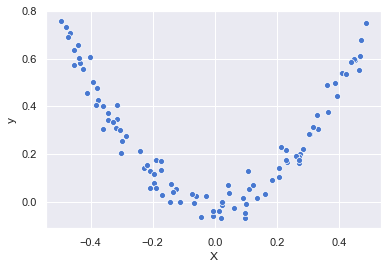

In [ ]:
sns.scatterplot(x="X", y="y", data=data)
plt.show()

## Basic classes and functions

### Boosted ensemble

To get started, we need a data structure that will represent our _boosted_ ensemble of regression trees. As a first guess, the variables we'll need to initialise our ensemble might include:

* `n_trees`: how many trees or "stages" we sequentially add to the ensemble
* `learning_rate`: a hyperparameter to control the contribution of each tree
* `max_depth`: a hyperparameter to control how deep each regression tree is (typically we want weak learners, i.e. shallow trees)

Unlike lesson 3, we will follow the _fit-predict_ paradigm of scikit-learn and pass `X` and `y` in a dedicated `fit` function. With these considerations, let's go ahead and build our boosted ensemble class!

In [ ]:
del LSBoost
del LeastSquares

In [ ]:
class LSBoost:
    def __init__(self, n_trees: int = 100, learning_rate: float = 0.1, max_depth: int = 3):
        self.n_trees = n_trees
        self.learning_rate = learning_rate
        self.max_depth = max_depth

        self.loss = LeastSquares()
        self.trees = [self.create_tree() for _ in range(self.n_trees)]

    def create_tree(self):
        return DecisionTreeRegressor(max_depth=self.max_depth)

    def fit(self, X, y):
        pass

    def predict(self, X):
        pass

### Define the loss function

Next let's try to instantiate our class:

In [ ]:
lsb = LSBoost(n_trees=3)

NameError: name 'LeastSquares' is not defined

Aha, we forgot to define our loss function! Following the analysis from Friedman's paper, for the LSBoost algorithm we need the Least Squares loss function

$$ L(y, F_M(X)) = \frac{1}{2}\sum_{i=1}^N \left(y_i - F_M(x_i) \right)^2 $$

which can be implemented in code as follows:

In [ ]:
class LeastSquares:
    def __init__(self):
        pass

    def loss(self, y, y_pred):
        return 0.5 * (y - y_pred) ** 2

    def gradient(self, y, y_pred):
        return -(y - y_pred)

Now that the loss function is defined, we can now instantiate our ensemble class:

In [ ]:
LSBoost.loss = LeastSquares()

In [ ]:
lsb = LSBoost(n_trees=3)
lsb.trees

[DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impur

### Build the ensemble

At the moment we just have an ensemble of tree regressors that have been _initialised_ but not yet fit to data. To remedy that, recall that we first initialise a model with a _constant_ value

$$ F_0(x) = \bar{y}$$

and then update this constant value by fitting regression trees to the gradient of the loss, also referred to as the _pseudo-residuals_:

$$ \tilde{y}_i = - \left[ \frac{\partial L(y_i, F(x_i)}{\partial F(x_i)} \right]_{F(x)=F_{m-1}(x)} = y_i - F_{m-1}(x_i) \,, \qquad i = 1, \ldots , N$$

Once the tree is fit to the gradients, we update the predictors as follows:

$$ F_{m+1}(X) = F_m(X) + \eta h_m(X)$$

where $\eta$ is the learning rate. We can implement these steps in code as follows:

In [ ]:
def fit(self, X, y):
    # initial model - in this case the mean
    y_pred = np.full(np.shape(y), np.mean(y, axis=0))
    for i in progress_bar(range(self.n_trees)):
        gradient = self.loss.gradient(y, y_pred)
        # negative gradient equivalent to pseudo-residuals
        self.trees[i].fit(X, -gradient)
        # generate predictions from current tree
        update = self.trees[i].predict(X)
        # update prediction from composite model
        y_pred += self.learning_rate * update

Next let's override the base function of our class and fit to the training set:

In [ ]:
LSBoost.fit = fit

lsb.fit(X, y)

Let's test whether this is working as expected by visualising a single tree in our ensemble:

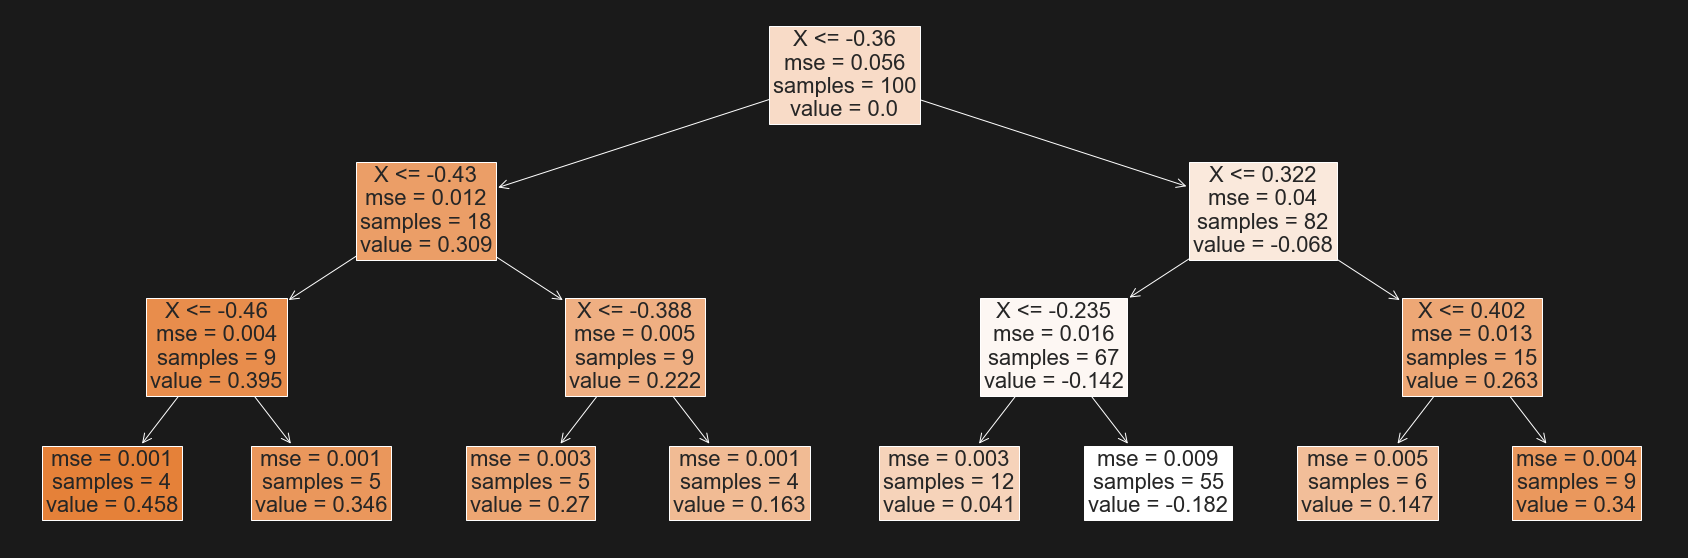

In [ ]:
plot_regression_tree(lsb.trees[0], data.columns, fontsize=22)

Comparison with scikit-learn's implementation yields a consistent result

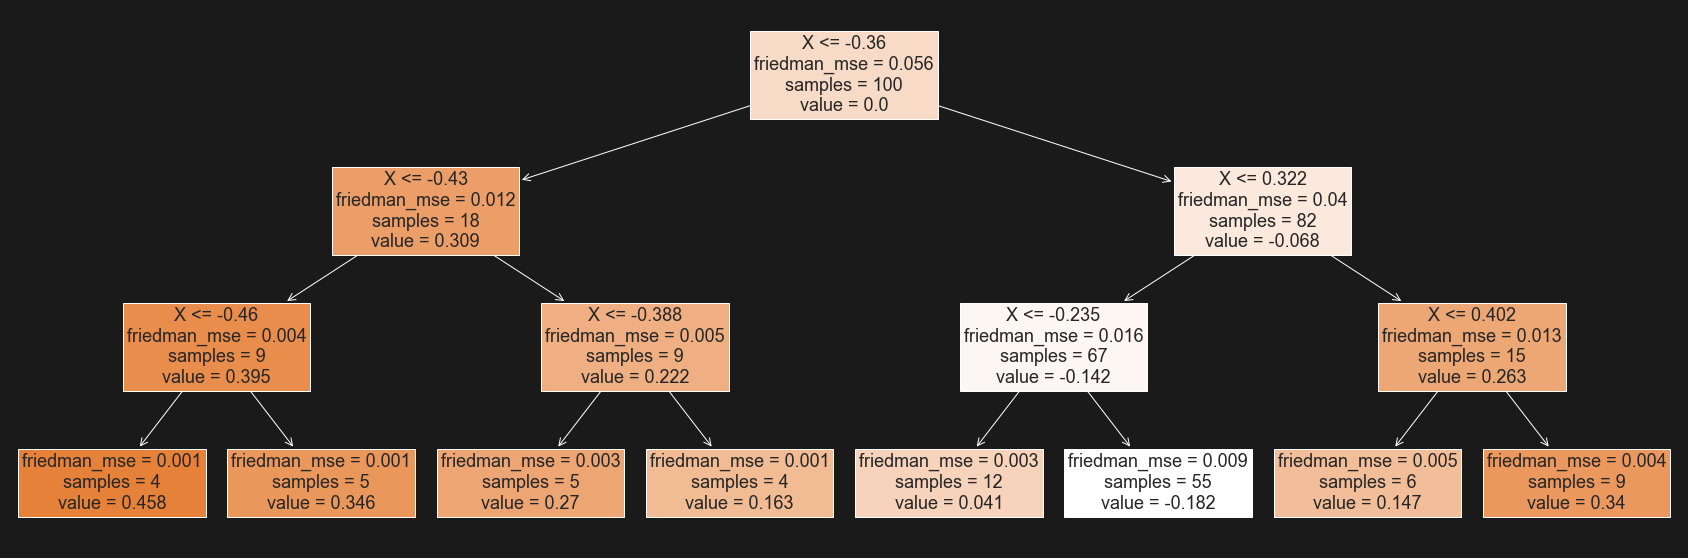

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=3)
gbr.fit(X, y)

plot_regression_tree(gbr.estimators_[0][0], data.columns, fontsize=18)

and thus we can be confident that we've successfully implemented the first two steps of the LSBoost algorithm (namely adding a predictions of a single tree to the mean of $y$)!

### Generate predictions

The final step is to implement the functionality to generate predictions. As we saw in lesson 4, this is quite simple as we just need to add the predictions of each regression tree, weighted by the learning rate:

In [ ]:
def predict(self, X):
    # initial prediction F_0
    initial_pred = np.full(np.shape(y), np.mean(y, axis=0))
    # composite tree predictions F_1 ... F_M
    tree_preds = sum(self.learning_rate * tree.predict(X) for tree in self.trees)
    return initial_pred + tree_preds

Let's override our base function and compare the error our model makes against the scikit-learn implementation:

In [ ]:
LSBoost.predict = predict

In [ ]:
def calculate_model_error(learning_rate, n_trees, max_depth):
    lsb = LSBoost(n_trees=n_trees, learning_rate=learning_rate, max_depth=max_depth)
    lsb.fit(X, y)
    lsb_preds = lsb.predict(X)
    
    gbr = GradientBoostingRegressor(n_estimators=n_trees)
    gbr.fit(X, y)
    gbr_preds = lsb.predict(X)
    
    print(f'MSE: {mean_squared_error(gbr_preds, lsb_preds):.16f}')

In [ ]:
n_trees, max_depth, learning_rate = 100, 3, 0.5

calculate_model_error(learning_rate, n_trees, max_depth)

MSE: 0.0000000000000000


<div style="text-align: center">
<img src='images/bam.jpg'>
</div>

As a final sanity check, let's see if we can recover the boosting predictions from lesson 4:

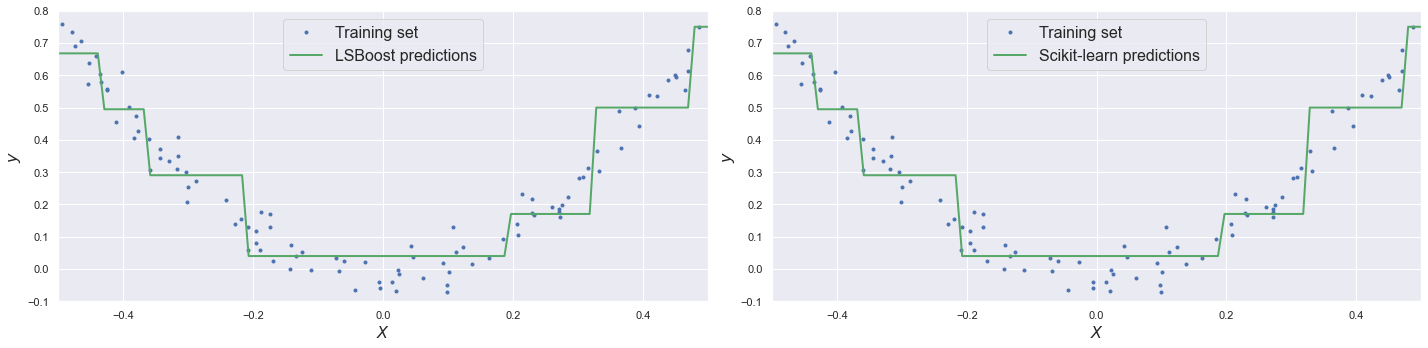

In [ ]:
n_trees, max_depth, learning_rate = 3, 2, 1.0

lsb = LSBoost(learning_rate=learning_rate, n_trees=n_trees, max_depth=max_depth)
lsb.fit(X, y)

gbr = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_trees, max_depth=max_depth)
gbr.fit(X, y)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20,5))

plt.subplot(ax0)
plot_predictions(
    [lsb], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="LSBoost predictions", style="g-", data_label="Training set"
)

plt.subplot(ax1)
plot_predictions(
    [lsb], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Scikit-learn predictions", style="g-", data_label="Training set"
)
plt.tight_layout()

## Gradient boosting on the SUSY dataset

Now that we have understand how basic gradient boosting works, let's return to our SUSY dataset from previous lessons and apply gradient boosting to binary classification using scikit-learn's estimator and an experimental, but high-performance version based on [histograms](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting). 

### Load data

In [ ]:
download_dataset("susy_sample.feather")

Download of susy_sample.feather dataset complete.


In [ ]:
DATA = Path("../data")
!ls {DATA}

susy.csv.gz         susy_sample.feather susy_train.feather
susy.feather        susy_test.feather


With pathlib it is a simple matter to define the filepath to the dataset, and since the file is in Feather format we can load it as a `pandas.DataFrame` as follows:

In [ ]:
susy_sample = pd.read_feather(DATA / "susy_sample.feather")
susy_sample.head()

,signal,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,1.0,0.821395,-0.103436,0.168752,1.051992,0.431800,-1.210648,0.428240,-1.663188,0.475450,-0.020242,0.795758,0.704858,0.786029,0.776712,0.792950,0.623655,0.770409,0.196300
1,1.0,0.907188,-1.143420,1.317695,1.299381,-1.839876,-0.160823,0.988608,-0.829973,1.395849,-0.646217,0.963228,1.139413,1.049706,1.399592,1.019565,1.157555,1.484495,0.179817
2,0.0,0.659807,-1.977303,-1.410509,0.990329,-1.701409,0.249222,0.499979,-0.509796,0.737884,0.661397,0.659569,0.609093,0.819481,0.000000,0.671145,0.397877,1.439343,0.054367
3,0.0,0.720814,-0.863228,0.222717,0.502039,0.472637,-1.134090,0.829423,-1.630658,0.984676,-0.509003,0.685277,0.898880,1.163993,0.885574,0.733956,0.942846,1.475507,0.365486
4,1.0,0.672261,1.264989,-0.032661,0.560856,0.086291,1.542801,1.705778,0.219045,1.099387,2.002287,0.646456,0.835348,1.146685,0.000000,0.692432,0.779301,1.543818,0.308604


In [ ]:
# sanity check on number of events
assert len(susy_sample) == 100_000

Next we create the feature matrix $X$ and target vector $y$, along with the training and validation sets:

In [ ]:
X = susy_sample.drop("signal", axis=1)
y = susy_sample["signal"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset split: {len(X_train)} train rows + {len(X_valid)} valid rows")

Dataset split: 80000 train rows + 20000 valid rows


### Baseline

To get started lets create a baseline model using the default parameters of scikit-learn:

In [ ]:
gbc = GradientBoostingClassifier(random_state=42)

%time gbc.fit(X_train, y_train)

CPU times: user 39 s, sys: 88.7 ms, total: 39 s
Wall time: 39.1 s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

We can score this model using our evaluation function from previous lessons:

In [ ]:
def print_scores(fitted_model):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:": roc_auc_score(
            y_train, fitted_model.predict_proba(X_train)[:, 1]
        ),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(
            y_valid, fitted_model.predict_proba(X_valid)[:, 1]
        ),
    }
    if hasattr(fitted_model, "oob_score_"):
        res["OOB accuracy:"] = fitted_model.oob_score_

    for k, v in res.items():
        print(k, round(v, 3))

In [ ]:
print_scores(gbc)

Accuracy on train: 0.802
ROC AUC on train: 0.875
Accuracy on valid: 0.801
ROC AUC on valid: 0.87


With a ROC AUC score of 0.87, our gradient boosted model is as good as the tuned Random Forest from lesson 2! Compared to the benchmark models in the SUSY article

<div style="text-align: center">
<img src='images/susy_benchmark.png'>
   <p style="text-align: center;"> <b>Figure reference:</b> https://www.nature.com/articles/ncomms5308 </p>
</div>

we're also doing better than their Boosted Decision Tree (BDT) model and within 0.5-1% of the neural network based approaches. Let's see if we can make our model a bit better.


### Speeding things up

One major drawback with the `GradientBoostingClassifier` implementation is that it's extremely _slow_, partly because gradient boosting involves adding models _sequentially_ and cannot be trivially parallelised like Random Forests. However, there are a few popular algorithms with provide significant performance speed-ups:

* [XGBoost](https://xgboost.readthedocs.io/en/latest/): for many years, this algorithm was the key ingredient behind Kaggle competitions.
* [LightGBM](https://lightgbm.readthedocs.io/en/latest/): the new kid on the block, providing considerable performance gains over XGBoost.

Between them, these two algorithms represent the current state-of-the-art for training regression and classification models on tabular data (although see [here](https://arxiv.org/pdf/1604.06737.pdf) for an example where deep learning yields the winning solution).

In this lesson, we will experiment with scikit-learn's historgram-based gradient boosting algorithm, which resembles LightGBM.

First we need to import the relevant class:

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

> Note: as noted in the scikit-learn documentation, these estimators are still experimental, but will likely become stable in an upcoming release.

In [ ]:
hgb = HistGradientBoostingClassifier(random_state=42)

%time hgb.fit(X_train, y_train)

CPU times: user 15.2 s, sys: 3.29 s, total: 18.4 s
Wall time: 1.42 s


HistGradientBoostingClassifier(l2_regularization=0.0, learning_rate=0.1,
                               loss='auto', max_bins=255, max_depth=None,
                               max_iter=100, max_leaf_nodes=31,
                               min_samples_leaf=20, n_iter_no_change=None,
                               random_state=42, scoring=None, tol=1e-07,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False)

In [ ]:
print_scores(hgb)

Accuracy on train: 0.814
ROC AUC on train: 0.892
Accuracy on valid: 0.8
ROC AUC on valid: 0.873


With a speedup of around 25x this isn't bad at all! We've also managed to boost our performance on the validation set using just the default parameters 🤓. We can also make things a little faster by employing early stopping in the same manner as lesson 4:

In [ ]:
hgb = HistGradientBoostingClassifier(
    max_iter=100, validation_fraction=0.2, n_iter_no_change=5, tol=1e-5, random_state=42, warm_start=True
)
%time hgb.fit(X_train, y_train)

CPU times: user 11.2 s, sys: 1.5 s, total: 12.7 s
Wall time: 1.01 s


HistGradientBoostingClassifier(l2_regularization=0.0, learning_rate=0.1,
                               loss='auto', max_bins=255, max_depth=None,
                               max_iter=100, max_leaf_nodes=31,
                               min_samples_leaf=20, n_iter_no_change=5,
                               random_state=42, scoring=None, tol=1e-05,
                               validation_fraction=0.2, verbose=0,
                               warm_start=True)

In [ ]:
print(f"Optimal number of trees: {hgb.n_iter_}")
print(f"Minimum validation cross-entropy loss: {np.min(hgb.validation_score_)}")

Optimal number of trees: 42
Minimum validation cross-entropy loss: 0.5421875


### Tuning the learning rate and number of trees

In gradient boosting, the key hyperparameter to tune are the learning rate and number of "stages" or tree in the ensemble. Let's use randomised search to find a potential set of optimal values (we include `max_depth` for good measure):

In [ ]:
# define range of values for each hyperparameter
param_dist = [
    {
        "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
        "max_iter": [100, 250, 500, 1000],
        "max_depth": [2, 3, 5, 10]
    }
]

# instantiate baseline model
model = HistGradientBoostingClassifier()

# initialise random search with cross-validation
random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=40, cv=5, scoring="roc_auc", n_jobs=-1
)

In [ ]:
# this is a RAM hungry monster, so best fed on a laptop!
%time random_search.fit(X, y)

CPU times: user 41.8 s, sys: 5.45 s, total: 47.3 s
Wall time: 3min 28s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=HistGradientBoostingClassifier(l2_regularization=0.0,
                                                            learning_rate=0.1,
                                                            loss='auto',
                                                            max_bins=255,
                                                            max_depth=None,
                                                            max_iter=100,
                                                            max_leaf_nodes=31,
                                                            min_samples_leaf=20,
                                                            n_iter_no_change=None,
                                                            random_state=None,
                                                            scoring=None,
                                                            tol=1e-07,
                                

Once the search is finished, we can get the best combination of parameters

In [ ]:
random_search.best_params_

{'max_iter': 500, 'max_depth': 3, 'learning_rate': 0.1}

along with the best model:

In [ ]:
best_model = random_search.best_estimator_

In [ ]:
cv_results = random_search.cv_results_

for score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(f"{score:.3f}", params)

0.871 {'max_iter': 1000, 'max_depth': 2, 'learning_rate': 0.3}
0.873 {'max_iter': 500, 'max_depth': 2, 'learning_rate': 0.2}
0.851 {'max_iter': 500, 'max_depth': 5, 'learning_rate': 0.001}
0.859 {'max_iter': 500, 'max_depth': 5, 'learning_rate': 0.3}
0.865 {'max_iter': 1000, 'max_depth': 2, 'learning_rate': 0.01}
0.870 {'max_iter': 500, 'max_depth': 3, 'learning_rate': 0.3}
0.864 {'max_iter': 1000, 'max_depth': 10, 'learning_rate': 0.1}
0.872 {'max_iter': 100, 'max_depth': 10, 'learning_rate': 0.1}
0.870 {'max_iter': 100, 'max_depth': 5, 'learning_rate': 0.3}
0.873 {'max_iter': 500, 'max_depth': 2, 'learning_rate': 0.3}
0.854 {'max_iter': 1000, 'max_depth': 10, 'learning_rate': 0.3}
0.845 {'max_iter': 250, 'max_depth': 2, 'learning_rate': 0.01}
0.871 {'max_iter': 100, 'max_depth': 3, 'learning_rate': 0.5}
0.869 {'max_iter': 1000, 'max_depth': 3, 'learning_rate': 0.01}
0.872 {'max_iter': 500, 'max_depth': 10, 'learning_rate': 0.01}
0.869 {'max_iter': 100, 'max_depth': 10, 'learning_rate

In [ ]:
susy_test = pd.read_feather(DATA/'susy_test.feather')
X_test, y_test = susy_test.drop("signal", axis=1), susy_test["signal"]

In [ ]:
# calculate probabilities per class
probs = best_model.predict_proba(X_test)[:, 1]

# evaluate against ground truth
roc_auc_score(y_test, probs)

0.8743053705162624

## Exercises

* Implement gradient boosting from scratch for classification tasks. This is somewhat tricky - see [here](https://www.youtube.com/watch?v=StWY5QWMXCw) for the relevant ingredients.
* Pick one of the XGBoost or LightGBM libraries and see if you can use them to beat our ROC AUC score from the histogram-based classifier.